In [8]:
import pandas as pd
import numpy as np
import os
import cv2 # 이미지 처리
from PIL import Image # 이미지 처리 (선택적)
import matplotlib.pyplot as plt # 시각화
import seaborn as sns # 시각화 (matplotlib 기반)

# Jupyter Notebook/Google Colab에서 plot이 보이도록 설정
%matplotlib inline

# 데이터 경로 수정
data_dir = 'diabetic-retinopathy-detection'  # 데이터 폴더명
data_path = os.path.join(data_dir, 'trainLabels.csv')  # CSV 파일 경로
base_image_dir = os.path.join(data_dir, 'train')       # 이미지 폴더 경로

# CSV 불러오기
df = pd.read_csv(data_path)

# 레이블 매핑 (이전 코드에서 사용했던 매핑)
label_mapping = {
    'No_DR':0,
    'Mild':1,
    'Moderate':2,
    'Severe':3,
    'Proliferate_DR':4
}
# 역매핑도 준비해두면 시각화에 편리합니다.
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

print(f"Loaded DataFrame head:\n{df.head()}")
print(f"Total images in DataFrame: {len(df)}")

Loaded DataFrame head:
      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1
Total images in DataFrame: 35126


**이미지 형식, 해상도, 크기 분포 확인**



Finished collecting metadata.
Missing images count: 0

--- Image Resolution Distribution ---
3888x2592    10352
4752x3168     5550
3504x2336     4144
2560x1920     3858
2592x1944     3795
3456x2304     1628
4928x3264     1558
4272x2848      854
3008x2000      836
2816x1880      508
1792x1184      414
4288x2848      322
3215x2136      298
3072x2048      264
2496x1664      178
3088x2056      166
2196x1957      116
3264x2448      108
3872x2592       66
5184x3456       26
2124x2056       24
400x315         19
2544x1696       16
1620x1444       10
1444x1444        6
2048x1536        4
433x289          2
1600x1216        2
2500x1666        2
Name: count, dtype: int64


C:\Users\asia\AppData\Local\Temp\ipykernel_32536\4116756146.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=resolution_counts.index[:10], y=resolution_counts.values[:10], palette='viridis')


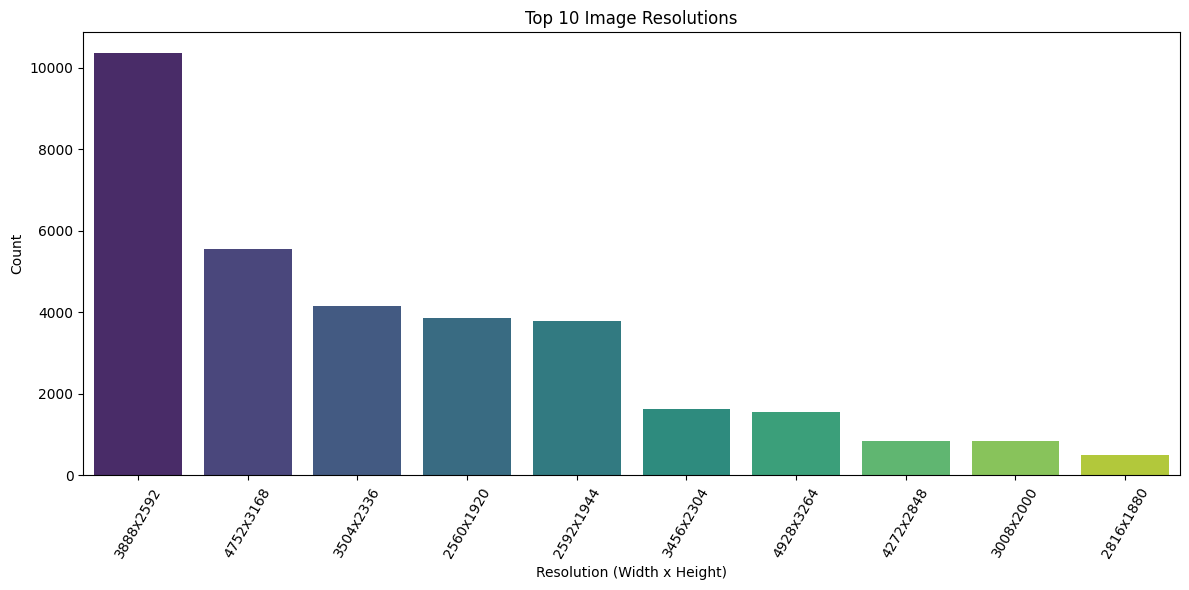


--- Image Channel Distribution ---
3    35126
Name: count, dtype: int64

--- Image Format Distribution ---
.jpeg    35126
Name: count, dtype: int64


In [9]:
# --- 이미지 메타데이터 수집 코드 수정 ---
image_resolutions = []
image_channels = []
image_formats = []
missing_images = []

print("\nCollecting image metadata (this might take a while for large datasets)...")

# ProgressBar를 위한 TQDM (선택 사항, Colab이나 Jupyter에서 진행 상황 확인에 유용)
# from tqdm.notebook import tqdm # Jupyter/Colab용
# for index, row in tqdm(df.iterrows(), total=len(df), desc="Collecting Metadata"):

for index, row in df.iterrows():
    # 새 데이터셋에서는 'image' 컬럼이 이미지 파일 이름을 나타냅니다.
    img_filename = row['image'] + '.jpeg' # 'image' 컬럼 값 + '.jpeg'

    # 이미지 파일 경로 구성:
    # 가장 흔한 경우는 모든 이미지가 base_image_dir 바로 아래에 있는 경우입니다.
    # 예: 'all_images/10_left.png'
    img_path = os.path.join(base_image_dir, img_filename)

    # 만약 이미지가 'level' (진단 단계)별 폴더에 나뉘어 있다면 아래와 같이 수정:
    # img_path = os.path.join(base_image_dir, str(row['level']), img_filename)
    # 예: 'colored_images/0/10_left.png'

    if os.path.exists(img_path):
        try:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR) # 컬러 이미지로 로드
            if img is not None:
                h, w, c = img.shape # 높이, 너비, 채널 수
                image_resolutions.append(f"{w}x{h}") # 가로x세로 형태로 저장
                image_channels.append(c)
                image_formats.append(os.path.splitext(img_path)[1]) # 파일 확장자 (예: .png)
            else:
                print(f"Warning: Could not read image at {img_path}. It might be corrupted.")
                missing_images.append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            missing_images.append(img_path)
    else:
        # print(f"Image not found: {img_path}") # 너무 많으면 주석 처리
        missing_images.append(img_path) # 누락된 이미지 경로를 리스트에 추가

print(f"\nFinished collecting metadata.")
print(f"Missing images count: {len(missing_images)}")
if len(missing_images) > 0:
    print(f"Sample missing images: {missing_images[:5]}")

# --- EDA 결과 출력 및 시각화 (기존 코드와 동일, 컬럼명만 'level'로 변경) ---

# 해상도 분포
print("\n--- Image Resolution Distribution ---")
resolution_counts = pd.Series(image_resolutions).value_counts()
print(resolution_counts)
# 가장 흔한 해상도 몇 개 시각화 (상위 10개)
plt.figure(figsize=(12, 6)) # 플롯 크기 확대
sns.barplot(x=resolution_counts.index[:10], y=resolution_counts.values[:10], palette='viridis')
plt.title('Top 10 Image Resolutions')
plt.xlabel('Resolution (Width x Height)')
plt.ylabel('Count')
plt.xticks(rotation=60) # x축 라벨 회전
plt.tight_layout() # 레이아웃 조정
plt.show()

# 채널 수 분포
print("\n--- Image Channel Distribution ---")
channel_counts = pd.Series(image_channels).value_counts()
print(channel_counts)
# 대부분 3 (컬러 이미지)일 것입니다.

# 이미지 형식 분포
print("\n--- Image Format Distribution ---")
format_counts = pd.Series(image_formats).value_counts()
print(format_counts)


**클래스별 이미지 수 확인**


--- Class Distribution ---
level
0    25810
1     2443
2     5292
3      873
4      708
Name: count, dtype: int64


C:\Users\asia\AppData\Local\Temp\ipykernel_32536\3014654075.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


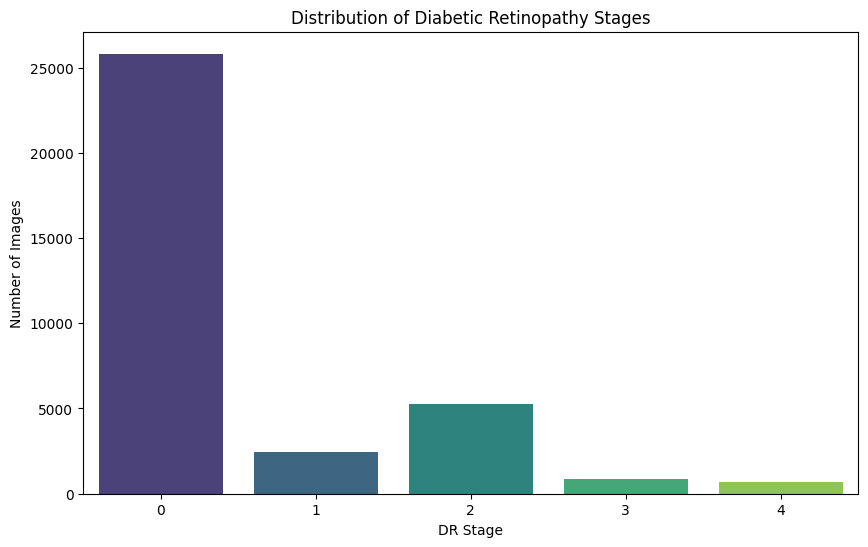


--- Class Distribution (Percentage) ---
level
0    73.48
1     6.95
2    15.07
3     2.49
4     2.02
Name: count, dtype: float64


In [10]:
print("\n--- Class Distribution ---")
class_counts = df['level'].value_counts().sort_index() # 진단명으로 정렬
print(class_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Diabetic Retinopathy Stages')
plt.xlabel('DR Stage')
plt.ylabel('Number of Images')
plt.show()

# 비율 계산
total_images_in_df = len(df)
print("\n--- Class Distribution (Percentage) ---")
print((class_counts / total_images_in_df * 100).round(2))

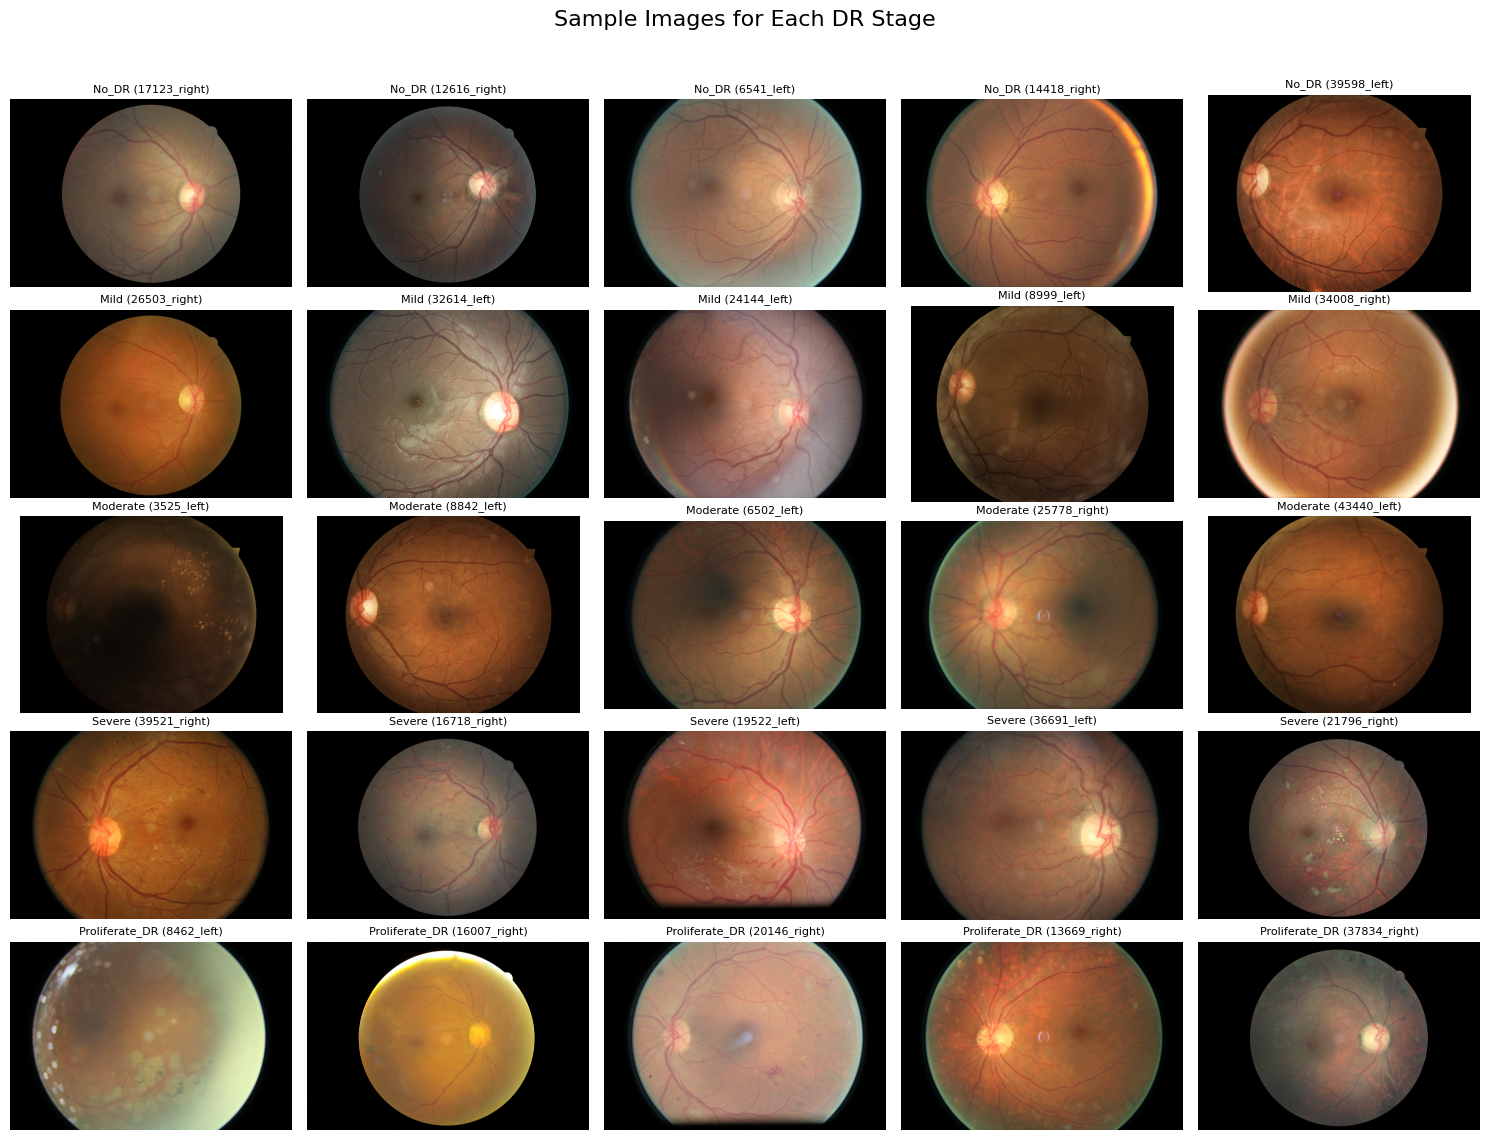


--- Checking Data Quality (Visual Inspection) ---
While viewing sample images from the previous step, pay attention to:
1. Bluriness or poor focus.
2. Uneven lighting or glare.
3. Dust, smudges, or other artifacts on the lens/image.
4. Areas of the retina that are not clearly visible.
5. Compression artifacts if images are heavily compressed (e.g., JPEG with low quality).

If significant quality issues are present, consider:
 - Applying additional pre-processing steps (e.g., contrast enhancement, noise reduction).
 - Filtering out extremely low-quality images if their number is small.


In [12]:
# 각 클래스별로 몇 개의 샘플 이미지를 볼 것인지 설정
samples_per_class = 5

plt.figure(figsize=(15, 12)) # 전체 플롯 크기 조정 (세로를 조금 더 늘림)

# label_mapping은 {'No_DR':0, 'Mild':1, ...} 형태입니다.
# 우리가 필요한 것은 숫자 레이블(0, 1, 2, 3, 4)로 데이터를 필터링하고
# 해당 레이블의 이름을 플롯 제목에 사용하는 것입니다.

# label_mapping을 순회하는 대신, 숫자 레이블(level)을 기준으로 순회합니다.
# sorted(label_mapping.values())는 [0, 1, 2, 3, 4]를 반환합니다.
for label_num in sorted(label_mapping.values()):
    # 숫자 레이블(label_num)에 해당하는 진단명(label_name)을 reverse_label_mapping에서 가져옵니다.
    label_name = reverse_label_mapping[label_num]

    # 해당 진단 레벨(숫자)에 해당하는 이미지들 필터링
    class_df = df[df['level'] == label_num] # <-- 여기가 핵심 변경! label_name 대신 label_num 사용

    # 샘플 이미지들을 무작위로 선택 (해당 클래스에 이미지가 충분하지 않을 경우를 대비하여 min 사용)
    sample_ids = class_df['image'].sample(min(samples_per_class, len(class_df)), random_state=42)

    for i, img_id in enumerate(sample_ids):
        # subplot 위치 계산
        # 5개 클래스 * samples_per_class + (현재 인덱스 + 1)
        plot_idx = label_num * samples_per_class + (i + 1)
        plt.subplot(len(label_mapping), samples_per_class, plot_idx)

        img_filename = img_id + '.jpeg' # 이미지 파일 확장자 .jpeg로 고정

        # 이미지 경로 구성: base_image_dir 바로 아래에 모든 이미지가 있다고 가정
        img_path = os.path.join(base_image_dir, img_filename) # <-- 여기가 핵심 변경! label_name 폴더 제거

        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV는 BGR, Matplotlib은 RGB
                plt.imshow(img)
                plt.title(f"{label_name} ({img_id})", fontsize=8) # 제목에는 진단명 사용
                plt.axis('off')
            else:
                plt.title(f"Error loading {label_name} {img_id}")
                plt.axis('off')
        else:
            plt.title(f"Missing {label_name} {img_id}")
            plt.axis('off')

plt.suptitle('Sample Images for Each DR Stage', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # 제목 공간 확보
plt.show()

# 원본 데이터의 품질(노이즈, 아티팩트 등)
print("\n--- Checking Data Quality (Visual Inspection) ---")
print("While viewing sample images from the previous step, pay attention to:")
print("1. Bluriness or poor focus.")
print("2. Uneven lighting or glare.")
print("3. Dust, smudges, or other artifacts on the lens/image.")
print("4. Areas of the retina that are not clearly visible.")
print("5. Compression artifacts if images are heavily compressed (e.g., JPEG with low quality).")
print("\nIf significant quality issues are present, consider:")
print(" - Applying additional pre-processing steps (e.g., contrast enhancement, noise reduction).")
print(" - Filtering out extremely low-quality images if their number is small.")